In [46]:
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from functions import *

from tqdm import tqdm

In [47]:
@dataclass
class Config:
    nx: int = 400
    ny: int = 200
    steps: int = 50000
    output_stride: int = 200
    molecular_weights: tuple[float, float, float] = (30, 30)

    stripe_width: int = 10

    base_pressure_A: float = 0.05
    base_pressure_B: float = 0.95
    stripe_pressure_A: float = 0.95
    stripe_pressure_B: float = 0.05

    initial_ux: float = 0.0
    initial_uy: float = 0.0

    total_pressure: float = 1.0
    theta: float = 0.5
    nB: int = 5

In [48]:
def initialise_stripe(config: Config):
    """Build initial distributions for a vertical A stripe and B elsewhere.

    Returns
    -------
    f : np.ndarray
        Populations, shape (2, 9, nx, ny)
    phi : xp.ndarray
        Equation-of-state factors, shape (2,)
    """
    nx, ny = config.nx, config.ny
    N = 2
    phi = 1.0 / xp.array(config.molecular_weights, dtype=xp.float64)  # EOS factors

    # Partial pressures per species
    pA = xp.full((nx, ny), config.base_pressure_A, dtype=xp.float64)
    pB = xp.full((nx, ny), config.base_pressure_B, dtype=xp.float64)
    s0 = nx // 2 - config.stripe_width // 2
    s1 = s0 + config.stripe_width
    pA[s0:s1, :] = config.stripe_pressure_A
    pB[s0:s1, :] = config.stripe_pressure_B

    # Convert partial pressures to densities: p_sigma = phi_sigma * rho_sigma / 3
    rhoA = 3.0 * pA / phi[0]
    rhoB = 3.0 * pB / phi[1]
    rho_s = xp.stack([rhoA, rhoB], axis=0)  # (2, nx, ny)

    # Build initial equilibrium with a small rightward velocity
    f = xp.zeros((N, 9, nx, ny), dtype=xp.float64)
    ux_s = xp.full((N, nx, ny), config.initial_ux, dtype=xp.float64)
    uy_s = xp.full((N, nx, ny), config.initial_uy, dtype=xp.float64)
    feq = equilibrium(f, rho_s, phi, ux_s, uy_s)
    f[...] = feq
    return f, phi

In [49]:
def diffusion_profile(f):
    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
    profile = rho_s[0, :, Config.ny/2]

    #plt.plot(to_numpy(profile))
    return profile



def profile_std(profile, background):
    profile = profile - background
    x = xp.arange(len(profile))
    total_mass = xp.sum(profile)
    x_mean = xp.sum(x * profile) / total_mass
    variance = xp.sum(profile * (x - x_mean) ** 2) / total_mass
    std = xp.sqrt(variance)
    return std

In [50]:
def main(absorption_coefficient):
    cfg = Config()
    out_dir = 'demo_frames'

    f, phi = initialise_stripe(cfg)
    molecular_weights = xp.array(cfg.molecular_weights, dtype=xp.float64)

    profiles = []
    stds = []

    for step in tqdm(range(cfg.steps + 1)):
        if step % cfg.output_stride == 0:
            save_concentration_frames(f, phi, step, molecular_weights)
        if step == cfg.steps:
            break
        f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_stream, step, absorption_coefficient)

        profile = diffusion_profile(f)
        profiles.append(to_numpy(profile))
        '''
        if step == 0:
            background = profile[300]
            print(background)
        std = profile_std(profile, background)
        stds.append(std)
        '''
    print(f"Saved frames to {out_dir}")

    return f, profiles#, stds

In [6]:
absorption_coefficient = 100
f, profiles= main(absorption_coefficient)

100%|█████████▉| 50000/50001 [12:26<00:00, 66.96it/s]

Saved frames to demo_frames


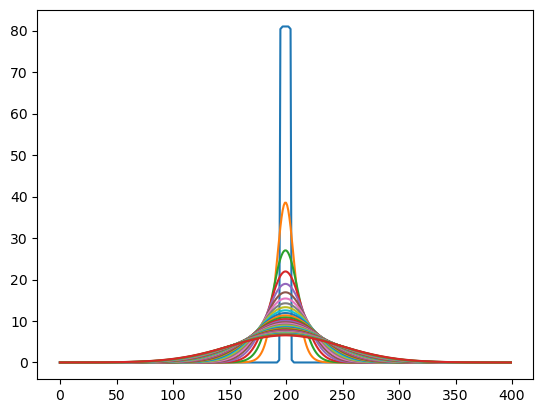

In [39]:
for i in range(Config.steps):
    if i % 1500 ==1:
        plt.plot(to_numpy(profiles[i]))


In [38]:
background = profiles[0][300]
profiles = xp.array(profiles-background)

stds = []

for i in range(Config.steps):
    stds.append(profile_std(profiles[i], background))

stds = to_numpy(xp.array(stds))

Diffusion_constant =  [0.02485489]


C:\Users\19162\AppData\Local\Temp\ipykernel_27768\2043486428.py:6: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*D*t)


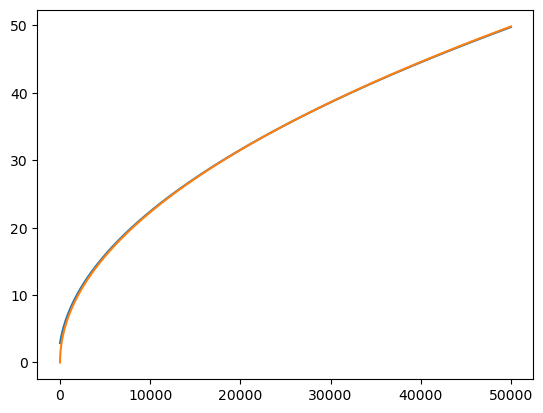

In [45]:
from scipy.optimize import curve_fit

plt.plot(stds)

def function_diffusion(t, D):
    return np.sqrt(2*D*t)

t_axis = np.arange(Config.steps)
popt, pcov = curve_fit(function_diffusion, t_axis, stds)

print("Diffusion_constant = ", popt)
plt.plot(t_axis, function_diffusion(t_axis, popt))